In [1]:
#Importing Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
#Importaing Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = CIFAR10(root='data/', download=True, transform=transform)
test_set = CIFAR10(root='data/', train=False, transform=transform)

Files already downloaded and verified


## Data Analysis

In [3]:
#Inspecting training dataset
size_trainset = len(train_set)
print(f"Length of training dataset is {size_trainset}")

#Inspecting testing dataset
size_testset = len(test_set)
print(f"Length of testing dataset is {size_testset}")

Length of training dataset is 50000
Length of testing dataset is 10000


In [4]:
#Inspecting output classes
classes = train_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
total_classes = len(classes)
print(f"Total number of output classes are {total_classes} ")

Total number of output classes are 10 


In [6]:
#Identifying shape of image tensor
image, label = train_set[0]
image_shape = image.shape
image_shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label id: 2
Label (corresponding text): bird


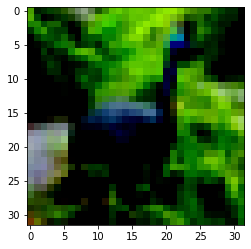

In [7]:
#As imshow expects images to be structured as (rows, columns, channels) values for RGB data
#We will rearrange original image tensor according to the desired ordering 
image, label = train_set[6]
plt.imshow(image.permute((1, 2, 0)))
print('Label id:', label)
print('Label (corresponding text):', classes[label])

## Preparing data for processing

In [8]:
# percentage of training set to use as validation
size_val = 0.2

# obtain training indices that will be used for validation
size_trainset = len(train_set)
indices = list(range(size_trainset))
np.random.shuffle(indices)
split = int(np.floor(size_val * size_trainset))
train_idx, valid_idx = indices[split:], indices[:split]

# defining sampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#loading training data for cnn in batches using DataLoader
train_loader_cnn = torch.utils.data.DataLoader(train_set, batch_size=20, sampler=train_sampler, num_workers=0)
valid_loader_cnn = torch.utils.data.DataLoader(train_set, batch_size=20, sampler=valid_sampler, num_workers=0)
test_loader_cnn = torch.utils.data.DataLoader(test_set, batch_size=10000, num_workers=0)

In [9]:
#loading training data for ann in batches using DataLoader
#setting seed to 80 for generating random numbers
torch.manual_seed(80)
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(test_set, batch_size=500, shuffle=False)

# Building ANN Model


In [10]:
class ANN(nn.Module):
    #We need to flatten the input size before feeding it to neural network
    def __init__(self, input_size=3*32*32, output_size=10):
        super().__init__()
        self._to_linear = None    
        self.fc1 = nn.Linear(input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [11]:
#creating a variable "artificial_nn" to call ANN() class
torch.manual_seed(80)
ann = ANN()
ann

ANN(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
#Creation of variable to calculate loss and to specify optimizer for ANN

cal_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ann.parameters(), lr=0.01)

# ANN Model Training

In [13]:
#creating empty list to calculate loss during training and to keep track of correct predictions
loss_train = []
loss_test = []
correct_train = []
correct_test  = []

epochs = 5
for i in range(epochs):
   
    trn_corr = 0
    tst_corr = 0
    batch_corr = 0
    

    for batch_iter, (X_train, y_train) in enumerate(train_loader):
      batch_iter +=1

      y_pred = ann(X_train.view(100, -1))
      loss = cal_loss(y_pred, y_train)
      
      predicted = torch.max(y_pred.data, 1)[1]
      batch_corr = (predicted == y_train).sum()
      trn_corr += batch_corr
      
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch_iter % 100 == 0:
        
        accuracy = trn_corr.item()*100 / (100*batch_iter)
        print( f'epoch: {i} batch {batch_iter} loss:{loss.item()} accuracy:{accuracy} ')
    
    loss_train.append(loss)
    correct_train.append(trn_corr)

    with torch.no_grad():
      
      for batch_iter, (X_test, y_test) in enumerate(test_loader):
        
        y_val = ann(X_test.view(500, -1))
        
        predicted = torch.max(y_val.data, 1)[1]
        tst_corr += (predicted == y_test).sum()
     
    loss = cal_loss(y_val,y_test)
    loss_test.append(loss)
    correct_test.append(tst_corr)



epoch: 0 batch 100 loss:2.2378265857696533 accuracy:18.01 
epoch: 0 batch 200 loss:2.1911234855651855 accuracy:21.495 
epoch: 0 batch 300 loss:2.0789241790771484 accuracy:23.59 
epoch: 0 batch 400 loss:1.9868152141571045 accuracy:24.99 
epoch: 0 batch 500 loss:1.9544250965118408 accuracy:26.14 
epoch: 1 batch 100 loss:1.9703329801559448 accuracy:33.72 
epoch: 1 batch 200 loss:1.708509087562561 accuracy:33.89 
epoch: 1 batch 300 loss:1.7958762645721436 accuracy:34.156666666666666 
epoch: 1 batch 400 loss:1.7531911134719849 accuracy:34.445 
epoch: 1 batch 500 loss:1.6724876165390015 accuracy:34.93 
epoch: 2 batch 100 loss:1.7133183479309082 accuracy:36.89 
epoch: 2 batch 200 loss:1.7739472389221191 accuracy:37.74 
epoch: 2 batch 300 loss:1.7772669792175293 accuracy:38.233333333333334 
epoch: 2 batch 400 loss:1.7329734563827515 accuracy:38.5075 
epoch: 2 batch 500 loss:1.5762051343917847 accuracy:38.83 
epoch: 3 batch 100 loss:1.6748138666152954 accuracy:41.45 
epoch: 3 batch 200 loss:1.7

# ANN Model Testing

In [14]:
#Loading all 10000 test images at once for prediction
load_testdata = DataLoader(test_set, batch_size=10000, shuffle=False)

with torch.no_grad():
  correct = 0
  for X_test, y_test in load_testdata: 
    y_val = ann(X_test.view(len(X_test),-1))
    predicted = torch.max(y_val,1)[1]
    correct = correct + (predicted == y_test).sum()
    accuracy_ann = 100 * correct.item()/len(test_set)
print(f'Accuracy on test set by ANN: {accuracy_ann}')

Accuracy on test set by ANN: 43.9


# Building CNN Model

In [15]:
# define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# create a variable "cnn" for CNN() class
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
#Creation of variable to calculate loss and to specify optimizer for ANN

cal_loss_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.SGD(cnn.parameters(), lr=.001)

# CNN Model Training

Epoch: 0 	Training Loss: 1.844081 	Validation Loss: 0.460762
Epoch: 1 	Training Loss: 1.842865 	Validation Loss: 0.460518
Epoch: 2 	Training Loss: 1.841891 	Validation Loss: 0.460275
Epoch: 3 	Training Loss: 1.840880 	Validation Loss: 0.460000
Epoch: 4 	Training Loss: 1.839630 	Validation Loss: 0.459636
Epoch: 5 	Training Loss: 1.837886 	Validation Loss: 0.459056
Epoch: 6 	Training Loss: 1.835159 	Validation Loss: 0.458009
Epoch: 7 	Training Loss: 1.829199 	Validation Loss: 0.455566
Epoch: 8 	Training Loss: 1.814076 	Validation Loss: 0.448615
Epoch: 9 	Training Loss: 1.779276 	Validation Loss: 0.434051
Epoch: 10 	Training Loss: 1.738838 	Validation Loss: 0.422447
Epoch: 11 	Training Loss: 1.702912 	Validation Loss: 0.412219
Epoch: 12 	Training Loss: 1.662938 	Validation Loss: 0.401526
Epoch: 13 	Training Loss: 1.626135 	Validation Loss: 0.392390
Epoch: 14 	Training Loss: 1.598227 	Validation Loss: 0.384828
Epoch: 15 	Training Loss: 1.570732 	Validation Loss: 0.377000
Epoch: 16 	Trainin

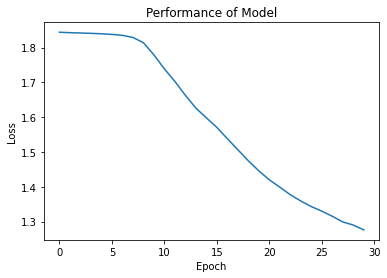

In [17]:
# number of epochs to train the model
n_epochs = [*range(30)]
#List to store loss to visualize
train_losslist = []
valid_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in n_epochs:

    # keeping track of train and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    cnn.train()
    for data, target in train_loader_cnn:
        # clearing gradient
        optimizer_cnn.zero_grad()
        output = cnn(data)
        loss = cal_loss_cnn(output, target)
        loss.backward()
        optimizer_cnn.step()
        train_loss = train_loss + loss.item()*data.size(0)
    cnn.eval()
    for data, target in valid_loader_cnn:
        output = cnn(data)
        loss = cal_loss_cnn(output, target)
        valid_loss = valid_loss + loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader_cnn.dataset)
    valid_loss = valid_loss/len(valid_loader_cnn.dataset)
    train_losslist.append(train_loss)
    valid_losslist.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

plt.plot(n_epochs, train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model")
plt.show()

# CNN Model Testing

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testing on test data
cnn.eval()
for data, target in test_loader_cnn:
    output = cnn(data)
    _, pred = torch.max(output, 1)    
    # comparing true label with predictions
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    # calculating accuracy
    batch_size = 20
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] = class_correct[label] + correct[i].item()
        class_total[label] = class_total[label] + 1
accuracy_cnn = 100 * np.sum(class_correct) / np.sum(class_total)
print(f'\nAccuracy on test set by CNN: {accuracy_cnn}%')


Accuracy on test set by CNN: 75.0%
